# Using Earth Access to Build and image

The goal is to use Earth Access to 

- load the rasters that cover Madison
- process them
- merge (or mosaic) them into one image

This is a reworking of 
[92-bulk-download](https://github.com/earthlab-education/fundamentals-04-redlining-byandell/blob/main/notebooks/redlining-92-bulk-download.ipynb).

In [1]:
city = "Madison"

In [2]:
import os # Interoperable file paths
import pathlib # Find the home folder

import geopandas as gpd # Work with vector data
import hvplot.pandas # Interactive plots of vector data
# conda install dask

In [3]:
pip install ~/Documents/GitHub/landmapy

Processing /Users/brianyandell/Documents/GitHub/landmapy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for landmapy: filename=landmapy-0.1-py3-none-any.whl size=16419 sha256=8bb78f5ead7ecff0e5ea5eba8ae1647cb79074a2add128db3b7c9fa7b8c7b8cb
  Stored in directory: /private/var/folders/tt/cyd1sy9s18l1fgc_0ty8l91w0000gn/T/pip-ephem-wheel-cache-kvzi2xrj/wheels/d4/8b/49/f05ffe83c93ff1cc194a4161d132e5ba0632f5ae288edbcd13
Successfully built landmapy
  Attempting uninstall: landmapy
    Found existing installation: landmapy 0.1
    Uninstalling landmapy-0.1:
      Successfully uninstalled landmapy-0.1
Note: you may need to restart the kernel to use updated packages.


In [19]:
import landmapy
from landmapy.redline import redline_gdf, plot_redline

In [16]:
# Define and create the project data directory
data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'redlining'
)
os.makedirs(data_dir, exist_ok=True)
data_dir

'/Users/brianyandell/earth-analytics/data/redlining'

/Users/brianyandell/miniconda3/envs/earth-analytics-python/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/brianyandell/earth-analytics/data/redlining/redlining/redlining.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


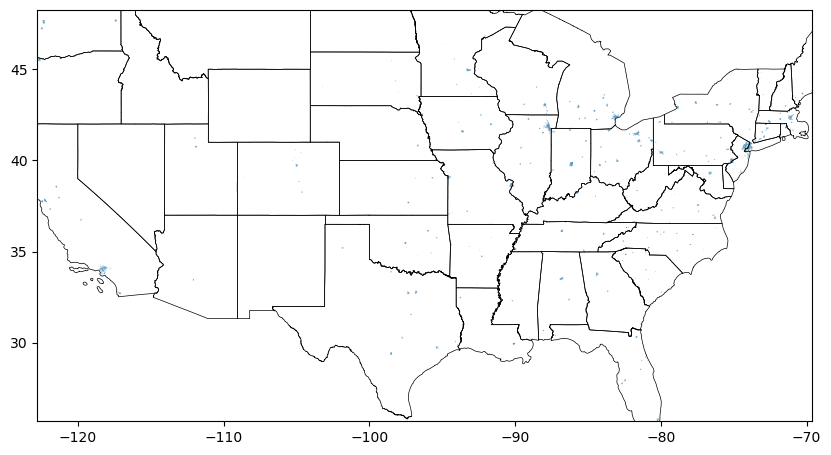

In [17]:
redlining_gdf = redline_gdf(data_dir)
plot_redline(redlining_gdf)

<Axes: >

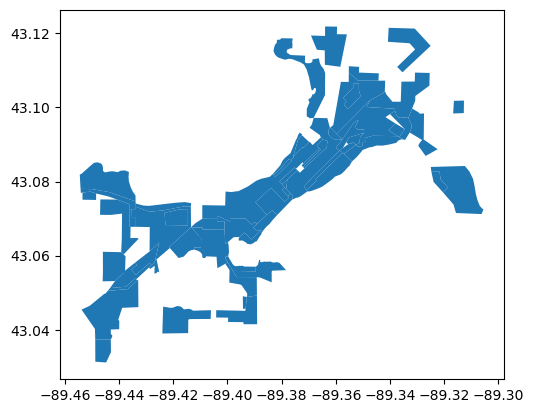

In [23]:
city_redlining_gdf = redlining_gdf[redlining_gdf.city == city]
city_redlining_gdf.plot()

## Set up Earth Access

The goal is to use Earth Access to

1. load the asters that cover selected `city`,
2. process them, and 
3. merge (or mosaic) them into one image

- Make an account on the [earthdata](https://urs.earthdata.nasa.gov/) site.
- Log in to your earthaccess account

In [29]:
import re # Use regular expressions to extract metadata

import earthaccess # Access NASA data from the cloud
import pandas as pd # Group and aggregate
import matplotlib.pyplot as plt # Overlay raster and vector data
import numpy as np # Process bit-wise cloud mask
import rioxarray as rxr # Work with raster data
from rioxarray.merge import merge_arrays # Merge rasters

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [12]:
earthaccess.login(strategy="interactive", persist=True)

- Search for the `city` data
- Open the file connections

In [15]:
# Search earthaccess
city_results = earthaccess.search_data(
    short_name="HLSL30",
    bounding_box=tuple(city_redlining_gdf.total_bounds),
    temporal=("2023-07-12", "2023-07-13"),
    count=1
)
city_files = earthaccess.open(city_results)

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

## Get metadata with regular expressions

Extract metadata from file names and put them into a DataFrame.
Later we can group rasters by their metadata values, such as `tile ID`, `band ID`, and/or `date`.

- Access `file_name` with a string version of the URI using `.full_name` attribute.
- Build regular expression to parse `file_name`
    - See https://regex101.com/ with Python regular expression engine.
- Add the URIs from earthaccess to the DataFrame you created as a new column.

In [16]:
city_files[1].full_name

'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16TCN.2023194T164028.v2.0/HLS.L30.T16TCN.2023194T164028.v2.0.B11.tif'

In [ ]:
# Compile a regular expression to search for metadata
uri_re = re.compile(
    r"HLS\.L30\."
    r"(?P<tile_id>T[0-9A-Z]+)\."  # `tile_id`
    r"(?P<date>\d+)T\d+\.v2\.0\." # `date` as `yyyyjjj` (year and Julian date)
    r"(?P<band_id>.+)\.tif")      # `band_id`
uri_re

re.compile(r'HLS\.L30\.(?P<tile_id>T[0-9A-Z]+)\.(?P<date>\d+)T\d+\.v2\.0\.(?P<band_id>.+)\.tif',
           re.UNICODE)

In [20]:
# Find all the metadata in the file name
uri_groups = [
    uri_re.search(city_file.full_name).groupdict()
    for city_file in city_files]

# Create a DataFrame with the metadata
raster_df = pd.DataFrame(uri_groups)

# Add the File-like URI to the DataFrame
raster_df['file'] = city_files

# Check the results
raster_df.head()

,tile_id,date,band_id,file
0,T16TCN,2023194,SAA,"<File-like object HTTPFileSystem, https://data..."
1,T16TCN,2023194,B11,"<File-like object HTTPFileSystem, https://data..."
2,T16TCN,2023194,B01,"<File-like object HTTPFileSystem, https://data..."
3,T16TCN,2023194,VZA,"<File-like object HTTPFileSystem, https://data..."
4,T16TCN,2023194,B09,"<File-like object HTTPFileSystem, https://data..."


## Create Process Functions

Build **DRY** (Don’t Repeat Yourself) code. That is, write once, use often.
Functions here are

- process_image()
- process_cloud_mask()

In [21]:
pip install ~/Documents/GitHub/landmapy

Processing /Users/brianyandell/Documents/GitHub/landmapy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for landmapy: filename=landmapy-0.1-py3-none-any.whl size=15469 sha256=1230ea60d9bd4156f327466765cf1f9b60f7a35120aff99b5d25d3156fb2f05d
  Stored in directory: /private/var/folders/tt/cyd1sy9s18l1fgc_0ty8l91w0000gn/T/pip-ephem-wheel-cache-dt8hva_j/wheels/d4/8b/49/f05ffe83c93ff1cc194a4161d132e5ba0632f5ae288edbcd13
Successfully built landmapy
  Attempting uninstall: landmapy
    Found existing installation: landmapy 0.1
    Uninstalling landmapy-0.1:
      Successfully uninstalled landmapy-0.1
Note: you may need to restart the kernel to use updated packages.


In [28]:
city_files

[<File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16TCN.2023194T164028.v2.0/HLS.L30.T16TCN.2023194T164028.v2.0.SAA.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16TCN.2023194T164028.v2.0/HLS.L30.T16TCN.2023194T164028.v2.0.B11.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16TCN.2023194T164028.v2.0/HLS.L30.T16TCN.2023194T164028.v2.0.B01.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16TCN.2023194T164028.v2.0/HLS.L30.T16TCN.2023194T164028.v2.0.VZA.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16TCN.2023194T164028.v2.0/HLS.L30.T16TCN.2023194T164028.v2.0.B09.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earth

In [30]:
from landmapy import process_image
help(process_image)

Help on module landmapy.process_image in landmapy:

NAME
    landmapy.process_image

FUNCTIONS
    process_image(uri, bounds_gdf)
        Load, crop, and scale a raster image from earthaccess
        
        Parameters
        ----------
        uri: file-like or path-like
          File accessor downloaded or obtained from earthaccess
        bounds_gdf: gpd.GeoDataFrame
          Area of interest to crop to
        
        Returns
        -------
        cropped_da: rxr.DataArray
          Processed raster

FILE
    /Users/brianyandell/miniconda3/envs/earth-analytics-python/lib/python3.11/site-packages/landmapy/process_image.py




In [ ]:
process_image(city_files[0], city_redlining_gdf).plot()

TypeError: 'module' object is not callable

In [29]:
blue_da = process_image(city_files[1], city_redlining_gdf)
city_cloud_mask = process_cloud_mask(
    city_files[-1],
    city_redlining_gdf,
    [1, 2, 3, 5])
blue_da.where(city_cloud_mask).plot()

TypeError: 'module' object is not callable

## Process Raster Files

Process all your bands using functions with appropriate arguments.
Caution that `DataFrames` tend to wrap values in external structures like `Series` (data type of columns in a `DataFrame`). To get a value out from inside a `Series`, use `.values[0]`, which removes the Series wrapper and the gets the first value in the array.

In [14]:
# Labels for each band to process
bands = {
    'B02': 'red',
    'B03': 'green',
    'B04': 'blue',
    'B05': 'nir'
}
# Initialize structure for saving images
denver_das = {band_name: [] for band_name in bands.values()}
print('Loading...')
for tile_id, tile_df in raster_df.groupby('tile_id'):
    print(tile_id)
    # Load the cloud mask
    fmask_file = tile_df[tile_df.band_id=='Fmask'].file.values[0]
    cloud_mask = process_cloud_mask(
        fmask_file, 
        denver_redlining_gdf, 
        [1, 2, 3, 5])

    for band_id, row in tile_df.groupby('band_id'):
        if band_id in bands:
            band_name = bands[band_id]
            print(band_id, band_name)
            # Process band
            band_da = process_image(
                row.file.values[0], 
                denver_redlining_gdf)

            # Mask band
            band_masked_da = band_da.where(cloud_mask)

            # Store the resulting DataArray for later
            denver_das[band_name].append(band_masked_da)

print('Done.')

Loading...
T13SDD
B02 red
B03 green
B04 blue
B05 nir
Done.


### Merge Tiles

In [15]:
# Merge all tiles
denver_merged_das = {
    band_name: merge_arrays(das) 
    for band_name, das 
    in denver_das.items()}

In [23]:
%store denver_merged_das

Stored 'denver_merged_das' (dict)


In [16]:
denver_merged_das.keys()

dict_keys(['red', 'green', 'blue', 'nir'])

Plot band merged across tiles.

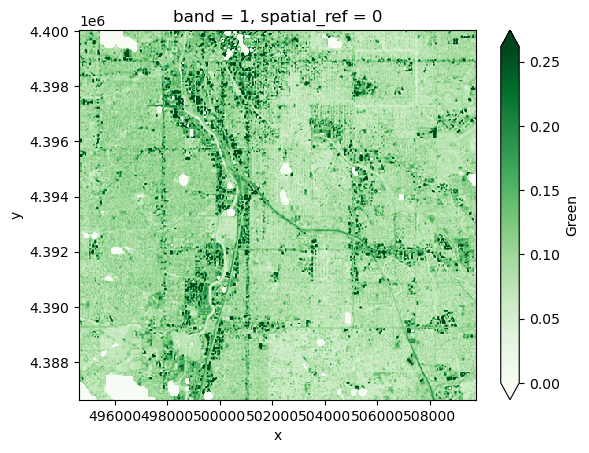

In [17]:
# Plot a merged raster band
denver_merged_das['green'].plot(cmap='Greens', robust=True)

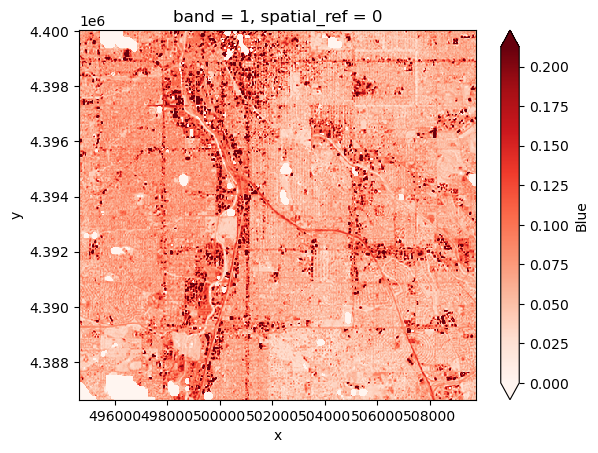

In [18]:
# Plot a merged raster band
denver_merged_das['red'].plot(cmap='Reds', robust=True)

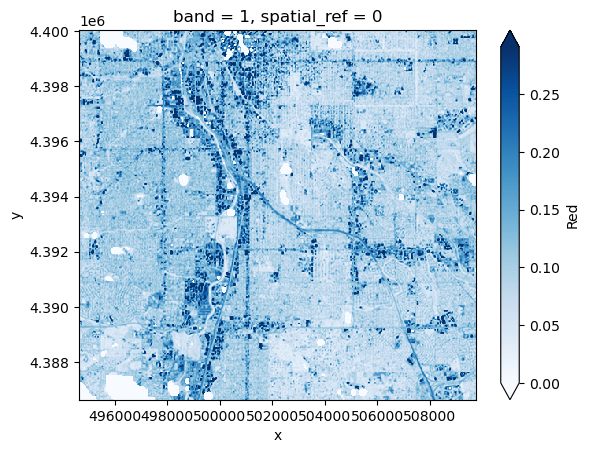

In [19]:
# Plot a merged raster band
denver_merged_das['blue'].plot(cmap='Blues', robust=True)

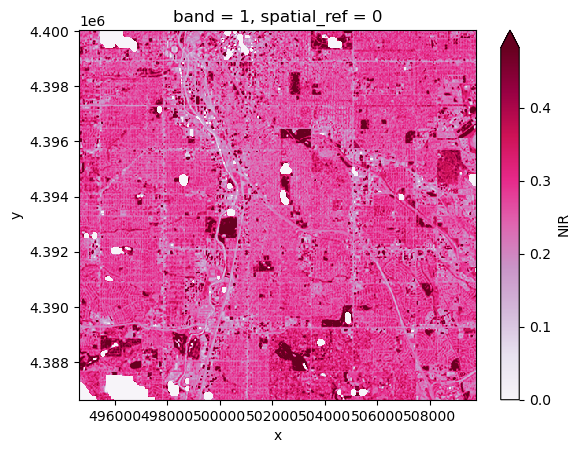

In [20]:
# Plot a merged raster band
denver_merged_das['nir'].plot(cmap='PuRd', robust=True)

There is a list of `colormaps`. See
[Choosing Colormaps in Matplotlib](https://matplotlib.org/stable/users/explain/colors/colormaps.html).

In [21]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viri

In [ ]:
denver_merged_das['red']

<xarray.DataArray (y: 447, x: 504)> Size: 901kB
array([[0.0567, 0.0757, 0.0682, ..., 0.0837, 0.0744, 0.0529],
       [0.0575, 0.0726, 0.0559, ..., 0.0907, 0.0849, 0.0605],
       [0.07  , 0.0672, 0.0625, ..., 0.0949, 0.0826, 0.0674],
       ...,
       [0.    , 0.    , 0.    , ..., 0.0712, 0.0498, 0.0477],
       [0.    , 0.    , 0.    , ..., 0.0565, 0.0412, 0.0382],
       [0.    , 0.    , 0.    , ..., 0.0602, 0.0575, 0.061 ]],
      dtype=float32)
Coordinates:
  * x            (x) float64 4kB 4.947e+05 4.947e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 4kB 4.4e+06 4.4e+06 4.4e+06 ... 4.387e+06 4.387e+06
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes: (12/33)
    ACCODE:                    Lasrc; Lasrc
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    arop_rmse(meters):         0, 0
    arop_s2_refimg:            NONE
    ...                        ...
    TIRS_SSM_MODEL:            UNKNOWN; UNKNOWN
    TIRS_SSM_POSITION_STATUS:  UNKNOWN; UNKNOWN
    ULX:                       399960
    ULY:                       4400040
    USGS_SOFTWARE:             LPGS_16.3.0
    AREA_OR_POINT:             Area